# Open Notebook & Additional Resources

<a target="_blank" href="https://colab.research.google.com/github/Nicolepcx/ORM-self-improving-ai-agents-course/blob/main/hands_on/session_02_HANDS_ON_reward_function.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://learning.oreilly.com/library/view/ai-agents-the/0642572247775/">
  <img src="https://img.shields.io/badge/AI%20Agents%20Book-Read%20on%20O'Reilly-d40101?style=flat" alt="AI Agents Book – Read on O'Reilly"/>
</a>




<font color="red" size="10">
<b>HANDS-ON TIME: 15 mins</b>
</font>

# Timer

In [3]:
SET_TIMER = False  # False, True, or minutes as a number

import requests, types
url = "https://raw.githubusercontent.com/Nicolepcx/ORM-self-improving-ai-agents-course/main/timer.py"

timer = types.ModuleType("timer")
exec(requests.get(url).text, timer.__dict__)

timer.start_exam_timer(enabled=SET_TIMER, minutes=15, warn_minutes=5)

# About this Notebook

## Frozen Lake: Reinforcement Learning Fundamentals

Welcome to the first hands-on session! To help you navigate the transition from a simple **Grid World** (Frozen Lake) to a **Large Language Model** (Agent), use this reference guide to map the concepts.

<br>

This notebook demonstrates the core concepts of reinforcement learning (RL) and how they directly translate to training **Self-Improving AI Agents**:

* **Policies ():** The "brain" of the agent. In this lab, it's a table; in an LLM, it's the model weights.
* **Rollouts:** Generating trajectories by interacting with the environment.
* **Trajectories ():** Sequences of states and actions (the "transcript" of an episode).
* **Rewards ():** Feedback signals that guide learning—the bridge between performance and optimization.

---

## 1. Environment Setup: From Grid to Agents

The **Frozen Lake** environment serves as your "Foundational Blueprint". While it looks like a simple game, the mechanics are identical to training an LLM agent to use tools or reason through a prompt. And it's actually the `Hello World` of RL.

### The Mapping

| Component | Frozen Lake (This Lab) | LLM Agent (Next Steps) |
| --- | --- | --- |
| **State ()** | Grid positions . | The conversation history + metadata. |
| **Action ()** | Move `up`, `down`, `left`, `right`. | Selecting the next **Token** or **Tool**. |
| **Policy ()** | Tabular weights + Softmax. | Transformer weights + Logits. |
| **Stochasticity** | "Slippery" tiles (random moves). | LLM **Temperature** (random generations). |

### The Reward Engine

You use **Reward Shaping** to guide the agent. Instead of a simple "win/loss," you use a cumulative signal:

* **Step Cost (-0.01):** Encourages efficiency. Analogous to penalizing "looping" or redundant reasoning in LLMs.
* **Terminal Reward (+1.0 / -1.0):** The final objective. Analogous to a successful tool execution or a correct math answer.
* **Total Reward:** $Step\_Cost \times Steps + Terminal\_Reward$


### 2. The Math of Decision Making

In the lab, you use a **Softmax** function to turn raw weights (logits) into a probability distribution. This is exactly how LLMs "decide" what to say next:

$$P(a|s) = \frac{e^{w_{s,a}}}{\sum_{a'} e^{w_{s,a'}}}$$

* **Logits($w$):** Higher weights mean the agent "prefers" that action.
* **Temperature:** While the local lab uses a standard softmax, LLMs use a temperature parameter ($T$) to scale these weights.
* **High $T$:** flattens the distribution (more random/creative).
* **Low $T$:** sharpens the distribution (more confident/robotic).



---

### 3. Learning via "Advantage" (The Path to GRPO)

In this lab, you update your policy using the **REINFORCE** algorithm. The core driver of learning is the **Advantage**  ($A$).

#### The Local Lab Version:

You use an **Exponential Moving Average** as your baseline ($b$). It represents what the agent expects to get on average.

$$A = \text{Actual Reward} (R) - \text{Baseline} (b)$$

* If $A > 0$:: The agent did better than average; you **increase** the probability of those actions.
* If $A < 0$: The agent did worse; you **decrease** the probability.

---

#### The GRPO Connection (Session 4 Preview):

In **Group Relative Policy Optimization (GRPO)**, you don't use a slow-moving historical baseline. Instead, you generate a **group** of trajectories (rollouts) for the *exact same prompt* simultaneously.

The Advantage for the -th trajectory in a group is calculated **relatively**:

$$A_i = \frac{R_i - \text{mean}(R_{group})}{\text{std}(R_{group})}$$

* **No Value Model:** Unlike standard RL (PPO), GRPO doesn't need a separate model to predict rewards. It uses the group itself to figure out what a "good" vs. "bad" answer looks like.
* **Efficiency:** This is exactly why we use `art.TrajectoryGroup` later in this course. It allows the model to look at 8 different ways it solved a math problem and say, *"The three that used fewer steps are my 'Good' examples ($A>0$), and the five that looped are my 'Bad' examples ($A<0$)."*

---

#### Why this matters for Self-Improving Agents:

By using **GSPO (Group Sequence Policy Optimization)**, you apply this same "relative" logic to multi-turn conversations and tool-use sequences. If an agent calls a tool effectively in one trajectory but fails in another, the **Advantage** signal tells the model exactly which "sequence of thoughts" led to the breakthrough.

This notebook is for the *Hands-on* for Session 1 for Develop Self-Improving AI Agents with Reinforcement Learning Live Event with O'Reilly Media by
[Nicole Koenigstein](https://www.linkedin.com/in/nicole-koenigstein/).


# Hands-on

<font color="red" size="10">
<b>TODO: </b>
</font>
<br>
<font color="black" size="5">
<b>Run the Notebook and examine how the learning takes place in the agent. </b>
</font>



In [ ]:
import random
import math
from typing import Literal, TypedDict, List, Tuple, Dict
from collections import defaultdict

# Actions
Action = Literal["up", "down", "left", "right"]
ACTIONS: List[Action] = ["up", "down", "left", "right"]

# Default 4x4 Frozen Lake map
# S = Start, F = Frozen (safe), H = Hole, G = Goal
DEFAULT_MAP = [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

class FrozenLakeGame(TypedDict):
    grid: List[List[str]]
    position: Tuple[int, int]
    steps: int
    trajectory: List[Tuple[int, int]]
    actions_taken: List[Action]
    reward: float
    success: bool

def create_game(map_layout: List[str] = None, slippery: float = 0.0) -> FrozenLakeGame:
    """
    Create a new Frozen Lake game.

    Args:
        map_layout: Grid layout (defaults to DEFAULT_MAP)
        slippery: Probability that action is replaced with random action (0.0 = deterministic)
    """
    if map_layout is None:
        map_layout = DEFAULT_MAP.copy()

    grid = [list(row) for row in map_layout]

    # Find start position
    start_pos = None
    for i, row in enumerate(grid):
        for j, tile in enumerate(row):
            if tile == "S":
                start_pos = (i, j)
                break
        if start_pos:
            break

    if start_pos is None:
        start_pos = (0, 0)

    game = {
        "grid": grid,
        "position": start_pos,
        "steps": 0,
        "trajectory": [start_pos],
        "actions_taken": [],
        "reward": 0.0,
        "success": False
    }
    game["_slippery"] = slippery  # Store slippery parameter
    return game

def render_game(game: FrozenLakeGame) -> str:
    """Render the game board with current position."""
    grid = game["grid"]
    pos = game["position"]

    result = ""
    for i, row in enumerate(grid):
        for j, tile in enumerate(row):
            if (i, j) == pos:
                result += "[A]"  # Agent position
            else:
                result += f" {tile} "
        result += "\n"
    return result

def get_tile(game: FrozenLakeGame, pos: Tuple[int, int]) -> str:
    """Get tile type at position."""
    i, j = pos
    grid = game["grid"]
    if 0 <= i < len(grid) and 0 <= j < len(grid[0]):
        return grid[i][j]
    return "H"  # Out of bounds = hole

def move_position(pos: Tuple[int, int], action: Action, grid: List[List[str]]) -> Tuple[int, int]:
    """Calculate new position after action. Uses dynamic grid size."""
    i, j = pos
    rows, cols = len(grid), len(grid[0])

    if action == "up":
        return (max(0, i - 1), j)
    elif action == "down":
        return (min(rows - 1, i + 1), j)
    elif action == "left":
        return (i, max(0, j - 1))
    elif action == "right":
        return (i, min(cols - 1, j + 1))
    return pos

def apply_action(game: FrozenLakeGame, action: Action) -> bool:
    """
    Apply action to game. Returns True if game continues, False if finished.
    Uses cumulative rewards: step cost + terminal reward.
    """
    # Apply slippery transition (stochasticity)
    slippery = game.get("_slippery", 0.0)
    if slippery > 0 and random.random() < slippery:
        action = random.choice(ACTIONS)  # Slip to random action

    new_pos = move_position(game["position"], action, game["grid"])
    tile = get_tile(game, new_pos)

    game["position"] = new_pos
    game["steps"] += 1
    game["trajectory"].append(new_pos)
    game["actions_taken"].append(action)

    # Cumulative reward: step cost (encourages efficiency)
    game["reward"] -= 0.01

    if tile == "H":
        # Fell into hole - add terminal penalty
        game["reward"] += -1.0
        return False
    elif tile == "G":
        # Reached goal - add terminal reward
        game["success"] = True
        game["reward"] += 1.0
        return False
    else:
        # Continue playing
        return True

def is_finished(game: FrozenLakeGame) -> bool:
    """Check if game is finished."""
    pos = game["position"]
    tile = get_tile(game, pos)
    return tile in ["H", "G"] or game["steps"] >= 100  # Max steps limit


# Policy Definition

A **policy** π(a|s) determines the probability of taking action `a` in state `s`. We'll use a simple tabular policy that stores action weights, which we normalize into probabilities using softmax.

The policy learns using REINFORCE-style policy gradient updates:
1. Start with uniform probabilities (equal weights)
2. Generate trajectories by sampling actions from the policy
3. Update weights using log-probability gradients scaled by advantage (reward - baseline)
4. Normalize weights to probabilities using softmax

This mirrors how LLM policies learn: the model outputs logits (weights), we sample actions, and update based on preference feedback (rewards).


In [ ]:
class TabularPolicy:
    """
    A tabular policy that learns using REINFORCE-style policy gradient.

    The policy stores logits (weights) per state-action pair, which are normalized
    into probabilities using softmax. Updates use log-probability gradients.
    """

    def __init__(self, learning_rate: float = 0.1, exploration_rate: float = 0.2,
                 baseline_decay: float = 0.9):
        """
        learning_rate: Step size for policy gradient updates
        exploration_rate: Epsilon for epsilon-greedy exploration
        baseline_decay: Exponential moving average decay for reward baseline
        """
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.baseline_decay = baseline_decay
        self.reward_baseline = 0.0  # Running average of rewards

        # State -> Action -> logit (weight)
        # Initialize with small positive weights (uniform after softmax)
        self.action_weights: Dict[Tuple[int, int], Dict[Action, float]] = defaultdict(
            lambda: {action: 0.0 for action in ACTIONS}
        )

    def _softmax_probs(self, weights: Dict[Action, float]) -> Dict[Action, float]:
        """Convert weights to probabilities using softmax."""
        # Subtract max for numerical stability
        max_weight = max(weights.values()) if weights.values() else 0.0
        exp_weights = {a: math.exp(w - max_weight) for a, w in weights.items()}
        total = sum(exp_weights.values())
        if total == 0:
            return {a: 1.0 / len(ACTIONS) for a in ACTIONS}  # Uniform if all zero
        return {a: exp_weights[a] / total for a in ACTIONS}

    def get_action_prob(self, state: Tuple[int, int], action: Action) -> float:
        """Get the probability of taking an action in a state."""
        weights = self.action_weights[state]
        probs = self._softmax_probs(weights)
        return probs.get(action, 0.0)

    def get_action(self, state: Tuple[int, int]) -> Action:
        """Sample an action from the policy for the given state."""
        # Epsilon-greedy: explore with probability exploration_rate
        if random.random() < self.exploration_rate:
            return random.choice(ACTIONS)

        # Sample according to policy probabilities
        weights = self.action_weights[state]
        probs = self._softmax_probs(weights)

        # Sample from distribution
        rand = random.random()
        cumulative = 0.0
        for action, prob in probs.items():
            cumulative += prob
            if rand <= cumulative:
                return action
        return ACTIONS[-1]  # Fallback

    def update_from_trajectory(self, trajectory: List[Tuple[int, int]],
                              actions: List[Action], reward: float):
        """
        REINFORCE-style policy gradient update.

        For each (state, action) in trajectory:
        - Compute log-probability of the taken action
        - Compute advantage: reward - baseline
        - Update: weight += learning_rate * advantage * grad_log_prob(action)

        Since we're using softmax, the gradient of log-prob is:
        grad_log_prob = 1 - prob(action) for the taken action
        grad_log_prob = -prob(action) for other actions
        """
        # Update baseline (exponential moving average)
        self.reward_baseline = (self.baseline_decay * self.reward_baseline +
                               (1 - self.baseline_decay) * reward)

        # Compute advantage
        advantage = reward - self.reward_baseline

        # Update each state-action pair in the trajectory
        for state, action in zip(trajectory[:-1], actions):  # Exclude final state
            weights = self.action_weights[state]
            probs = self._softmax_probs(weights)

            # REINFORCE update: gradient of log-probability
            # For taken action: grad_log_prob = 1 - prob(action)
            # For other actions: grad_log_prob = -prob(action)
            for a in ACTIONS:
                if a == action:
                    # Positive update for taken action
                    grad_log_prob = 1.0 - probs[a]
                else:
                    # Negative update for other actions
                    grad_log_prob = -probs[a]

                # Policy gradient update
                update = self.learning_rate * advantage * grad_log_prob
                weights[a] = weights[a] + update

                # Prevent weights from becoming too extreme (optional stability)
                weights[a] = max(-10.0, min(10.0, weights[a]))

    def get_policy_visualization(self, grid: List[List[str]]) -> Dict[Tuple[int, int], Action]:
        """Get the most likely action for each state (for visualization)."""
        policy_map = {}
        for i, row in enumerate(grid):
            for j, tile in enumerate(row):
                state = (i, j)
                if tile not in ["H", "G"]:  # Only show policy for reachable states
                    weights = self.action_weights[state]
                    probs = self._softmax_probs(weights)
                    best_action = max(probs.items(), key=lambda x: x[1])[0]
                    policy_map[state] = best_action
        return policy_map

    def get_policy_summary(self) -> Dict:
        """Get a summary of the current policy."""
        return {
            "num_states": len(self.action_weights),
            "learning_rate": self.learning_rate,
            "exploration_rate": self.exploration_rate,
            "reward_baseline": self.reward_baseline
        }


# Rollouts: Generating Trajectories

A **rollout** is a single episode where the agent interacts with the environment, generating a **trajectory** (sequence of states and actions) and receiving a **reward**.


In [ ]:
def rollout(policy: TabularPolicy, slippery: float = 0.0) -> FrozenLakeGame:
    """
    Generate a single rollout (trajectory) by following the policy.
    This is the core of RL: agent interacts with environment, generates trajectory.

    Args:
        policy: Policy to follow
        slippery: Probability of action being replaced with random (0.0 = deterministic)
    """
    game = create_game(slippery=slippery)

    while not is_finished(game):
        state = game["position"]
        action = policy.get_action(state)
        if not apply_action(game, action):
            break

    return game


# Reinforcement Learning Loop

The RL loop consists of:
1. **Rollout**: Generate trajectories using current policy
2. **Reward**: Calculate rewards for each trajectory
3. **Update**: Improve policy based on rewards
4. **Repeat**: Iterate to improve performance

Let's implement this loop and watch the policy learn!


In [ ]:
def train_policy(policy: TabularPolicy, num_iterations: int = 20,
                 rollouts_per_iteration: int = 10, slippery: float = 0.0) -> List[Dict]:
    """
    Train the policy using reinforcement learning.

    Args:
        policy: Policy to train
        num_iterations: Number of training iterations
        rollouts_per_iteration: Number of rollouts per iteration
        slippery: Probability of slippery transitions (0.0 = deterministic)

    Returns history of metrics for each iteration.
    """
    history = []

    for iteration in range(num_iterations):
        # Generate rollouts (trajectories)
        rollouts = []
        successes = 0

        for _ in range(rollouts_per_iteration):
            game = rollout(policy, slippery=slippery)
            rollouts.append(game)
            if game["success"]:
                successes += 1

        # Calculate metrics
        success_rate = successes / rollouts_per_iteration
        avg_reward = sum(r["reward"] for r in rollouts) / rollouts_per_iteration
        avg_steps = sum(r["steps"] for r in rollouts) / rollouts_per_iteration

        # Update policy based on rewards (this is the learning step!)
        for game in rollouts:
            policy.update_from_trajectory(
                game["trajectory"],
                game["actions_taken"],
                game["reward"]
            )

        history.append({
            "iteration": iteration + 1,
            "success_rate": success_rate,
            "avg_reward": avg_reward,
            "avg_steps": avg_steps,
            "successes": successes
        })

    return history

# Initialize policy and train
random.seed(42)

# Adjust these parameters to see how they affect learning:
LEARNING_RATE = 0.1      # How quickly policy adapts (higher = faster learning)
EXPLORATION_RATE = 0.2   # Exploration vs exploitation (higher = more random)
NUM_ITERATIONS = 20       # Number of training iterations
ROLLOUTS_PER_ITER = 10   # Number of rollouts per iteration

policy = TabularPolicy(learning_rate=LEARNING_RATE, exploration_rate=EXPLORATION_RATE)

print("Training policy with reinforcement learning...")
print(f"Learning rate: {LEARNING_RATE}, Exploration rate: {EXPLORATION_RATE}")
print(f"Running {NUM_ITERATIONS} iterations with {ROLLOUTS_PER_ITER} rollouts each\n")

history = train_policy(policy, NUM_ITERATIONS, ROLLOUTS_PER_ITER)

# Print results
print("Training Progress:")
print(f"{'Iter':<6} {'Success Rate':<15} {'Avg Reward':<15} {'Avg Steps':<12} {'Successes':<10}")
print("-" * 70)
for h in history:
    print(f"{h['iteration']:<6} {h['success_rate']:>6.1%}        {h['avg_reward']:>8.3f}      {h['avg_steps']:>8.1f}      {h['successes']:>3}/{ROLLOUTS_PER_ITER}")


Training policy with reinforcement learning...
Learning rate: 0.1, Exploration rate: 0.2
Running 20 iterations with 10 rollouts each

Training Progress:
Iter   Success Rate    Avg Reward      Avg Steps    Successes 
----------------------------------------------------------------------
1        0.0%          -1.095           9.5        0/10
2        0.0%          -1.074           7.4        0/10
3       10.0%          -0.870           7.0        1/10
4        0.0%          -1.078           7.8        0/10
5        0.0%          -1.059           5.9        0/10
6        0.0%          -1.048           4.8        0/10
7       10.0%          -0.889           8.9        1/10
8        0.0%          -1.115          11.5        0/10
9        0.0%          -1.111          11.1        0/10
10       0.0%          -1.089           8.9        0/10
11       0.0%          -1.061           6.1        0/10
12       0.0%          -1.060           6.0        0/10
13       0.0%          -1.050           5

# Visualize Trajectories

Let's watch how the policy behaves after training. Notice how the trajectories change as the policy learns!


In [ ]:
# Visualize a few rollouts with the trained policy
NUM_VISUALIZATIONS = 3

print("Sample trajectories from trained policy:\n")
for i in range(NUM_VISUALIZATIONS):
    game = rollout(policy)

    print(f"=== Rollout {i+1} ===")
    print(f"Trajectory: {game['trajectory']}")
    print(f"Actions: {game['actions_taken']}")
    print(f"Reward: {game['reward']:.3f}")
    print(f"Steps: {game['steps']}")
    if game["success"]:
        print("✅ SUCCESS - Reached the goal!")
    else:
        print("❌ FAILED - Fell into a hole or timeout")
    print()


Sample trajectories from trained policy:

=== Rollout 1 ===
Trajectory: [(0, 0), (0, 0), (1, 0), (2, 0), (3, 0)]
Actions: ['left', 'down', 'down', 'down']
Reward: -1.040
Steps: 4
❌ FAILED - Fell into a hole or timeout

=== Rollout 2 ===
Trajectory: [(0, 0), (0, 0), (1, 0), (2, 0), (1, 0), (1, 0), (2, 0), (1, 0), (1, 1)]
Actions: ['up', 'down', 'down', 'up', 'left', 'down', 'up', 'right']
Reward: -1.080
Steps: 8
❌ FAILED - Fell into a hole or timeout

=== Rollout 3 ===
Trajectory: [(0, 0), (1, 0), (1, 1)]
Actions: ['down', 'right']
Reward: -1.020
Steps: 2
❌ FAILED - Fell into a hole or timeout



### Visualize the Learned Policy

Let's see what the policy learned by visualizing the most likely action in each state as arrows on the grid. This turns learning into a "map" you can inspect!


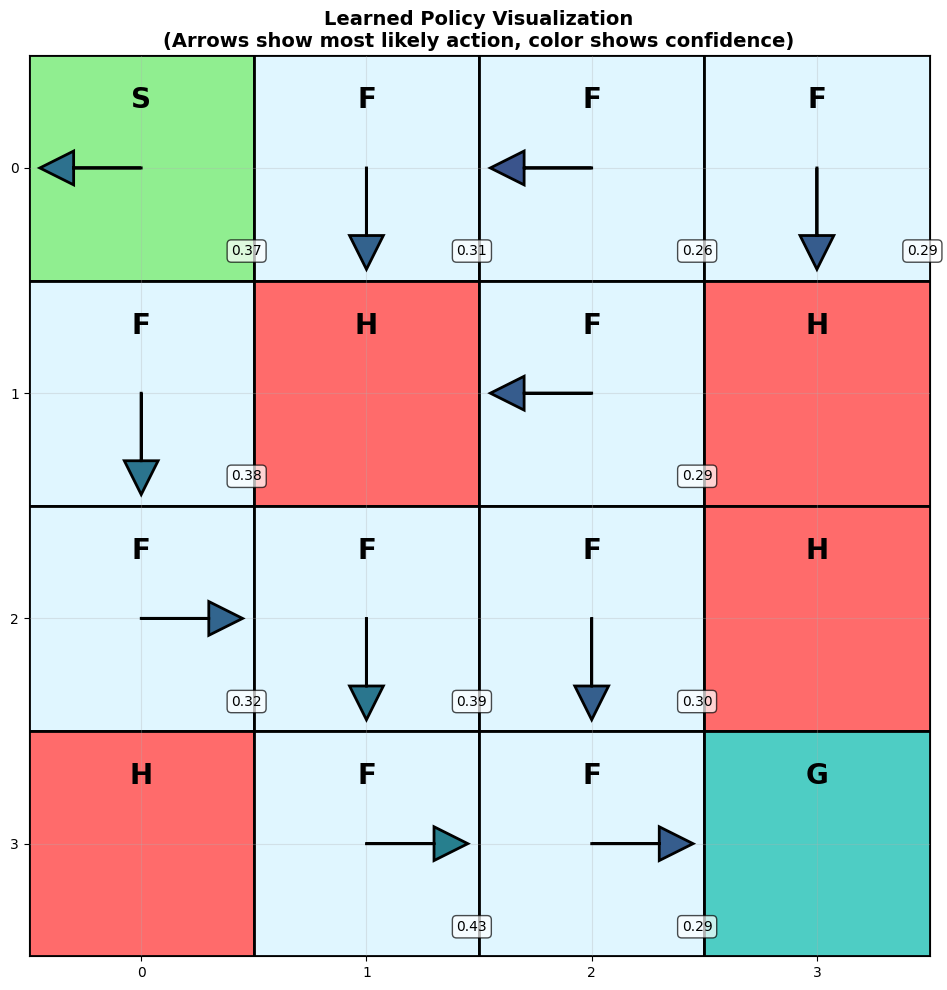


Policy Summary:
  States with learned policy: 11
  Reward baseline: -1.049

Sample state-action probabilities:
  State (0, 0):
    ← left : 0.369
      down : 0.335
      right: 0.162
      up   : 0.134
  State (0, 1):
    ← down : 0.311
      up   : 0.245
      right: 0.231
      left : 0.214
  State (0, 2):
    ← left : 0.260
      up   : 0.249
      right: 0.246
      down : 0.245


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_policy(policy: TabularPolicy, game: FrozenLakeGame):
    """
    Visualize the learned policy as arrows on the grid.
    Shows the most likely action (highest probability) for each state.
    """
    grid = game["grid"]
    policy_map = policy.get_policy_visualization(grid)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Color map for tiles
    tile_colors = {
        "S": "#90EE90",  # Light green for start
        "F": "#E0F6FF",  # Light blue for frozen
        "H": "#FF6B6B",  # Red for hole
        "G": "#4ECDC4"   # Teal for goal
    }

    # Arrow directions
    arrow_map = {
        "up": (0, -0.3),
        "down": (0, 0.3),
        "left": (-0.3, 0),
        "right": (0.3, 0)
    }

    # Draw grid
    rows, cols = len(grid), len(grid[0])
    for i, row in enumerate(grid):
        for j, tile in enumerate(row):
            color = tile_colors.get(tile, "#FFFFFF")
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                                facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(rect)

            # Add tile label
            ax.text(j, i-0.3, tile, ha='center', va='center',
                   fontsize=20, fontweight='bold')

            # Add policy arrow if state is reachable
            state = (i, j)
            if state in policy_map:
                action = policy_map[state]
                dx, dy = arrow_map[action]

                # Get probability for visual feedback
                prob = policy.get_action_prob(state, action)
                arrow_color = plt.cm.viridis(prob)  # Color by confidence

                ax.arrow(j, i, dx, dy, head_width=0.15, head_length=0.15,
                        fc=arrow_color, ec='black', linewidth=2, zorder=10)

                # Show probability as text
                ax.text(j + 0.4, i + 0.4, f'{prob:.2f}',
                       fontsize=10, ha='left', va='bottom',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(-0.5, rows - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert so (0,0) is top-left
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_title('Learned Policy Visualization\n(Arrows show most likely action, color shows confidence)',
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print policy summary
    print(f"\nPolicy Summary:")
    print(f"  States with learned policy: {len(policy_map)}")
    print(f"  Reward baseline: {policy.reward_baseline:.3f}")
    print(f"\nSample state-action probabilities:")
    sample_states = list(policy_map.keys())[:3]
    for state in sample_states:
        weights = policy.action_weights[state]
        probs = policy._softmax_probs(weights)
        print(f"  State {state}:")
        for action, prob in sorted(probs.items(), key=lambda x: x[1], reverse=True):
            marker = "←" if action == policy_map[state] else " "
            print(f"    {marker} {action:5s}: {prob:.3f}")

# Create a sample game to get the grid layout
sample_game = create_game()
visualize_policy(policy, sample_game)


# Video Visualization

Let's create an animated video showing the agent playing the game! This visualizes how the policy behaves in real-time.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML, display

def create_video_visualization(game: FrozenLakeGame, policy: TabularPolicy = None,
                              save_path: str = None, fps: int = 2) -> HTML:
    """
    Create an animated visualization of a game trajectory.

    Args:
        game: The completed game with trajectory
        policy: Optional policy to show action probabilities
        save_path: Optional path to save video file
        fps: Frames per second for animation
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    grid = game["grid"]
    trajectory = game["trajectory"]
    actions = game["actions_taken"]

    # Create color map for tiles
    tile_colors = {
        "S": "#90EE90",  # Light green for start
        "F": "#E0F6FF",  # Light blue for frozen
        "H": "#FF6B6B",  # Red for hole
        "G": "#4ECDC4"   # Teal for goal
    }

    # Create grid visualization
    grid_array = np.zeros((len(grid), len(grid[0])))
    for i, row in enumerate(grid):
        for j, tile in enumerate(row):
            grid_array[i, j] = hash(tile) % 100  # Simple hash for visualization

    # Plot grid
    im = ax.imshow(grid_array, cmap='Pastel1', aspect='equal', vmin=0, vmax=100)

    # Draw grid lines
    ax.set_xticks(np.arange(-0.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)

    # Add tile labels
    for i, row in enumerate(grid):
        for j, tile in enumerate(row):
            color = tile_colors.get(tile, "#FFFFFF")
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1,
                                facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(rect)
            ax.text(j, i, tile, ha='center', va='center',
                   fontsize=24, fontweight='bold')

    # Agent marker
    agent_marker, = ax.plot([], [], 'o', markersize=30, color='#FFD700',
                           markeredgecolor='black', markeredgewidth=2, zorder=10)

    # Trajectory line
    traj_line, = ax.plot([], [], '--', color='orange', linewidth=3, alpha=0.5, zorder=5)

    # Text for step info
    step_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                       fontsize=14, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.set_xlim(-0.5, len(grid[0]) - 0.5)
    ax.set_ylim(-0.5, len(grid) - 0.5)
    ax.set_xticks(range(len(grid[0])))
    ax.set_yticks(range(len(grid)))
    ax.invert_yaxis()  # Invert so (0,0) is top-left
    ax.set_title('Frozen Lake - Agent Trajectory', fontsize=16, fontweight='bold')

    def animate(frame):
        if frame < len(trajectory):
            pos = trajectory[frame]
            j, i = pos[1], pos[0]  # Note: matplotlib uses (x, y) = (col, row)

            # Update agent position
            agent_marker.set_data([j], [i])

            # Update trajectory line
            if frame > 0:
                traj_x = [p[1] for p in trajectory[:frame+1]]
                traj_y = [p[0] for p in trajectory[:frame+1]]
                traj_line.set_data(traj_x, traj_y)

            # Update step info
            action_str = f"Action: {actions[frame-1]}" if frame > 0 else "Start"
            step_text.set_text(f'Step: {frame}\n{action_str}\nPosition: {pos}')

            # Highlight current position
            if frame < len(trajectory) - 1:
                # Check if next step is goal or hole
                next_pos = trajectory[frame + 1] if frame + 1 < len(trajectory) else pos
                next_tile = get_tile(game, next_pos)
                if next_tile == "G":
                    step_text.set_text(f'Step: {frame}\n{action_str}\nPosition: {pos}\n🎯 Approaching Goal!')
                elif next_tile == "H":
                    step_text.set_text(f'Step: {frame}\n{action_str}\nPosition: {pos}\n⚠️ Approaching Hole!')
        else:
            # Final state
            pos = trajectory[-1]
            j, i = pos[1], pos[0]
            agent_marker.set_data([j], [i])

            if game["success"]:
                step_text.set_text(f'Step: {frame}\n✅ SUCCESS!\nReached Goal!\nReward: {game["reward"]:.2f}')
                agent_marker.set_color('#00FF00')  # Green for success
            else:
                step_text.set_text(f'Step: {frame}\n❌ FAILED!\nFell into Hole\nReward: {game["reward"]:.2f}')
                agent_marker.set_color('#FF0000')  # Red for failure

        return agent_marker, traj_line, step_text

    # Create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(trajectory) + 5,
                                  interval=1000/fps, blit=False, repeat=True)

    plt.tight_layout()

    # Save if path provided
    if save_path:
        Writer = animation.writers['ffmpeg'] if 'ffmpeg' in animation.writers.list() else None
        if Writer:
            writer = Writer(fps=fps, metadata=dict(artist='Frozen Lake RL'), bitrate=1800)
            anim.save(save_path, writer=writer)
            print(f"Video saved to {save_path}")
        else:
            print("FFmpeg not available. Install with: conda install -c conda-forge ffmpeg")

    # Display in notebook
    plt.close()  # Close to avoid duplicate display
    return HTML(anim.to_jshtml())

# Generate a rollout and visualize it
print("Generating a rollout and creating video visualization...\n")
demo_game = rollout(policy)

print(f"Trajectory length: {len(demo_game['trajectory'])} steps")
print(f"Success: {demo_game['success']}")
print(f"Reward: {demo_game['reward']:.3f}\n")

# Create and display the animation
video_html = create_video_visualization(demo_game, policy, fps=3)
display(video_html)


Generating a rollout and creating video visualization...

Trajectory length: 9 steps
Success: False
Reward: -1.080



/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())


### Save Video to File (Optional)

You can also save the animation as an MP4 video file if you have ffmpeg installed.


In [ ]:
import os
from IPython.display import Video, display

# 1. Ensure we find a successful run to show off
successful_game = None
print("Searching for a successful trajectory to record...")

for _ in range(50): # Increased attempts to ensure we find one
    g = rollout(policy)
    if g["success"]:
        successful_game = g
        break

if successful_game:
    video_filename = "frozen_lake_success.mp4"

    # 2. Generate and save the video
    # We pass save_path to trigger the ffmpeg writer
    create_video_visualization(successful_game, policy, save_path=video_filename, fps=4)

    # 3. Embed the video directly in the Colab output
    if os.path.exists(video_filename):
        print(f"\n✅ Video saved and rendered: {video_filename}")
        display(Video(video_filename, embed=True, width=600))
else:
    print("❌ Could not find a successful game in 50 attempts. Try training for more iterations!")

Searching for a successful trajectory to record...


/tmp/ipython-input-1290339484.py:127: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  anim.save(save_path, writer=writer)
/tmp/ipython-input-1290339484.py:127: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  anim.save(save_path, writer=writer)


Video saved to frozen_lake_success.mp4


/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())
/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())



✅ Video saved and rendered: frozen_lake_success.mp4


In [ ]:
# Create a fresh untrained policy for comparison
untrained_policy = TabularPolicy(learning_rate=0.1, exploration_rate=0.2)

print("=" * 70)
print("COMPARISON: Untrained vs Trained Policy")
print("=" * 70)

# Get a successful trajectory from trained policy
print("\n1. Trained Policy (after learning):")
trained_game = None
for _ in range(10):  # Try a few times to get a successful one
    g = rollout(policy)
    if g["success"]:
        trained_game = g
        break
if not trained_game:
    trained_game = rollout(policy)  # Use any if no success found

print(f"   Steps: {trained_game['steps']}, Success: {trained_game['success']}, Reward: {trained_game['reward']:.3f}")

# Get a trajectory from untrained policy
print("\n2. Untrained Policy (random start):")
untrained_game = None
for _ in range(10):
    g = rollout(untrained_policy)
    if g["success"]:
        untrained_game = g
        break
if not untrained_game:
    untrained_game = rollout(untrained_policy)

print(f"   Steps: {untrained_game['steps']}, Success: {untrained_game['success']}, Reward: {untrained_game['reward']:.3f}")

print("\n" + "=" * 70)
print("TRAINED POLICY VISUALIZATION:")
print("=" * 70)
trained_video = create_video_visualization(trained_game, policy, fps=3)
display(trained_video)

print("\n" + "=" * 70)
print("UNTRAINED POLICY VISUALIZATION:")
print("=" * 70)
untrained_video = create_video_visualization(untrained_game, untrained_policy, fps=3)
display(untrained_video)


COMPARISON: Untrained vs Trained Policy

1. Trained Policy (after learning):
   Steps: 13, Success: True, Reward: 0.870

2. Untrained Policy (random start):
   Steps: 3, Success: False, Reward: -1.030

TRAINED POLICY VISUALIZATION:


/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())
/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())



UNTRAINED POLICY VISUALIZATION:


/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())


## 7. Experiment: Adjust Policy Parameters

**Try adjusting these parameters to see how they influence learning:**

- **Learning Rate**: How quickly the policy adapts (higher = faster, but may be unstable)
- **Exploration Rate**: Balance between exploration and exploitation (higher = more random)
- **Number of Iterations**: How long to train
- **Rollouts per Iteration**: How many trajectories to generate per training step


In [ ]:
# EXPERIMENT: Adjust these parameters and re-run to see the effects!

CUSTOM_LEARNING_RATE = 0.15    # Try: 0.05 (slow), 0.1 (medium), 0.2 (fast)
CUSTOM_EXPLORATION_RATE = 0.15  # Try: 0.1 (exploit more), 0.3 (explore more)
CUSTOM_ITERATIONS = 25          # Try: 10 (quick), 30 (more training)
CUSTOM_ROLLOUTS = 15            # Try: 5 (fewer samples), 20 (more samples)

print("=" * 70)
print("EXPERIMENT: Training with different parameters")
print("=" * 70)
print(f"Learning Rate: {CUSTOM_LEARNING_RATE}")
print(f"Exploration Rate: {CUSTOM_EXPLORATION_RATE}")
print(f"Iterations: {CUSTOM_ITERATIONS}")
print(f"Rollouts per Iteration: {CUSTOM_ROLLOUTS}")
print()

# Create a fresh policy with new parameters
experiment_policy = TabularPolicy(
    learning_rate=CUSTOM_LEARNING_RATE,
    exploration_rate=CUSTOM_EXPLORATION_RATE
)

experiment_history = train_policy(
    experiment_policy,
    CUSTOM_ITERATIONS,
    CUSTOM_ROLLOUTS
)

# Compare initial vs final performance
initial_success = experiment_history[0]["success_rate"]
final_success = experiment_history[-1]["success_rate"]
improvement = final_success - initial_success

print("\n" + "=" * 70)
print("RESULTS:")
print("=" * 70)
print(f"Initial Success Rate: {initial_success:.1%}")
print(f"Final Success Rate: {final_success:.1%}")
print(f"Improvement: {improvement:+.1%}")
print(f"Final Avg Reward: {experiment_history[-1]['avg_reward']:.3f}")
print(f"Final Avg Steps: {experiment_history[-1]['avg_steps']:.1f}")

# Show learning curve
print("\nLearning Curve (Success Rate over iterations):")
for h in experiment_history[::max(1, len(experiment_history)//10)]:  # Sample every 10%
    bar_length = int(h["success_rate"] * 50)
    bar = "█" * bar_length
    print(f"Iter {h['iteration']:3d}: {bar} {h['success_rate']:.1%}")


EXPERIMENT: Training with different parameters
Learning Rate: 0.15
Exploration Rate: 0.15
Iterations: 25
Rollouts per Iteration: 15


RESULTS:
Initial Success Rate: 0.0%
Final Success Rate: 80.0%
Improvement: +80.0%
Final Avg Reward: 0.525
Final Avg Steps: 7.5

Learning Curve (Success Rate over iterations):
Iter   1:  0.0%
Iter   3: ███ 6.7%
Iter   5: ███ 6.7%
Iter   7:  0.0%
Iter   9: ███ 6.7%
Iter  11: █████████████ 26.7%
Iter  13: ████████████████ 33.3%
Iter  15: ██████████████████████████████ 60.0%
Iter  17: ████████████████████████████████████████ 80.0%
Iter  19: ██████████████████████████████ 60.0%
Iter  21: ██████████████████████████ 53.3%
Iter  23: █████████████████████████████████ 66.7%
Iter  25: ████████████████████████████████████████ 80.0%


### Visualize the Trained Policy

Let's see the trained policy in action! We'll show a few successful trajectories to see how well it learned.


In [ ]:
# Visualize the trained experiment policy
print("=" * 70)
print("VISUALIZING TRAINED POLICY IN ACTION")
print("=" * 70)
print(f"Final Success Rate: {final_success:.1%}")
print(f"Improvement: {improvement:+.1%}\n")

# Get a few successful trajectories to visualize
print("Generating successful trajectories from the trained policy...\n")
successful_games = []
attempts = 0
max_attempts = 50

while len(successful_games) < 3 and attempts < max_attempts:
    game = rollout(experiment_policy)
    if game["success"]:
        successful_games.append(game)
    attempts += 1

if successful_games:
    print(f"Found {len(successful_games)} successful trajectory(ies)!\n")
    for i, game in enumerate(successful_games, 1):
        print(f"{'=' * 70}")
        print(f"SUCCESSFUL TRAJECTORY {i}/{len(successful_games)}")
        print(f"{'=' * 70}")
        print(f"Steps: {game['steps']}")
        print(f"Reward: {game['reward']:.3f}")
        print(f"Trajectory: {game['trajectory']}")
        print(f"Actions: {game['actions_taken']}\n")

        # Create and display visualization
        video = create_video_visualization(game, experiment_policy, fps=3)
        display(video)
        print()
else:
    # If no successful games found, show the best one we got
    print("No successful trajectories found in 50 attempts.")
    print("Showing the best attempt:\n")
    best_game = rollout(experiment_policy)
    for _ in range(10):
        g = rollout(experiment_policy)
        if g["reward"] > best_game["reward"]:
            best_game = g

    print(f"Steps: {best_game['steps']}")
    print(f"Reward: {best_game['reward']:.3f}")
    print(f"Success: {best_game['success']}\n")

    video = create_video_visualization(best_game, experiment_policy, fps=3)
    display(video)


VISUALIZING TRAINED POLICY IN ACTION
Final Success Rate: 80.0%
Improvement: +80.0%

Generating successful trajectories from the trained policy...

Found 3 successful trajectory(ies)!

SUCCESSFUL TRAJECTORY 1/3
Steps: 9
Reward: 0.910
Trajectory: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (2, 2), (3, 2), (3, 2), (3, 3)]
Actions: ['down', 'down', 'right', 'down', 'right', 'up', 'down', 'down', 'right']



/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())
/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())



SUCCESSFUL TRAJECTORY 2/3
Steps: 7
Reward: 0.930
Trajectory: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 1), (3, 2), (3, 3)]
Actions: ['down', 'down', 'right', 'down', 'down', 'right', 'right']



/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())
/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())



SUCCESSFUL TRAJECTORY 3/3
Steps: 7
Reward: 0.930
Trajectory: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (3, 2), (3, 2), (3, 3)]
Actions: ['down', 'down', 'right', 'down', 'right', 'down', 'right']



/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())
/tmp/ipython-input-1290339484.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return HTML(anim.to_jshtml())


# Key Takeaways

This notebook demonstrates the core concepts of reinforcement learning for LLMs:

### **Policies**
- A policy determines what action to take in each state
- Policies can be improved through learning from experience
- The balance between exploration and exploitation is crucial

### **Rollouts & Trajectories**
- A **rollout** generates a trajectory by following the policy
- A **trajectory** is a sequence of (state, action) pairs
- Multiple rollouts provide diverse experience for learning

### **Rewards**
- Rewards provide feedback signals (positive for success, negative for failure)
- The policy learns by increasing probabilities of actions that led to high rewards
- Relative feedback (comparing trajectories) guides learning

### **The Learning Loop**
1. Generate rollouts using current policy
2. Calculate rewards for each trajectory
3. Update policy to favor actions from high-reward trajectories
4. Repeat to improve performance over time

### **Observations**
- **Learning Rate**: Too high can cause instability, too low learns slowly
- **Exploration Rate**: Need exploration to discover good strategies, but too much prevents exploitation
- **More Training**: Generally improves performance, but may plateau
- **More Rollouts**: Provides more stable learning signal

**Try adjusting the parameters in Section 6 to see how they affect the learning process!**
